# MLP on MNIST with fixed sign update

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
from matplotlib import rcParams

# rcParams['figure.figsize'] = [20, 4]
# rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Generate data

In [2]:
#@title Downloading data

train_dataset = datasets.CIFAR10(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_dataset = datasets.CIFAR10(root = './data', train = False,
                       transform = transforms.ToTensor())

Files already downloaded and verified


In [3]:
#@title Loading the data
batch_size = 100 # the size of input data took for one iteration
train_loader = DataLoader(dataset = train_dataset,batch_size = batch_size,shuffle = True)
test_loader = DataLoader(dataset = test_dataset,batch_size = batch_size,shuffle = False)

In [4]:
#@title Define Hyperparameters
image, label = train_dataset.__getitem__(0)
input_size = image.numel()
hidden_size = 500 # number of nodes at hidden layer
output_size = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
lr = 1e-3 # size of step

## Define model and optimizers

In [5]:
class EPLHb(nn.Module):
  def __init__(self, EP_size, LHb_size, DAN_size, prob_EP_to_LHb: float=1, fixed_sign: bool=False, neg_output: bool=True):
    super(EPLHb,self).__init__()
    self.EP_to_LHb = nn.Linear(EP_size, LHb_size, bias=True)
    # nn.init.xavier_normal_(self.EP_to_LHb.weight)
    self.LHb_to_DAN = nn.Linear(LHb_size, DAN_size, bias=True)
    # nn.init.xavier_normal_(self.LHb_to_DAN.weight)

    self.EP_size = EP_size
    self.LHb_size = LHb_size
    self.DAN_size = DAN_size
    
    with torch.no_grad():
      # Make EP to LHb sparse
      n_zeros = int((1-prob_EP_to_LHb) * self.EP_to_LHb.weight.numel())
      sparse_idx = torch.randperm(self.EP_to_LHb.weight.numel())[:n_zeros]
      self.EP_to_LHb.weight.data.view(-1)[sparse_idx] = 0
      
      # Make LHb to DAN all negative
      self.neg_output = neg_output
      if neg_output: self.LHb_to_DAN.weight.data = -torch.sign(self.LHb_to_DAN.weight)*self.LHb_to_DAN.weight

      # Turn into fixed sign (obey Dale's law)
      self.fixed_sign = fixed_sign
      pos_neurons = {}
      neg_neurons = {}
      if fixed_sign:
        for name, param in self.named_parameters():
          if "weight" in name:
            # Find each neuron is excitatory or inhibitory
            pos_neurons[name] = torch.sum(param.data, axis=0) >= 0
            neg_neurons[name] = torch.sum(param.data, axis=0) < 0
            # Make all weights of that neuron excitatory or inhibitory
            param.data[:,pos_neurons[name]] = torch.sign(param[:,pos_neurons[name]])*param[:,pos_neurons[name]]
            param.data[:,neg_neurons[name]] = -torch.sign(param[:,neg_neurons[name]])*param[:,neg_neurons[name]]
    
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

    # Store original weights information
    self.sparse_idx = sparse_idx
    self.pos_neurons = pos_neurons
    self.neg_neurons = neg_neurons
    self.init_weights = self.record_params(calc_sign=False)

  def enforce_weights(self):
    with torch.no_grad():
      # Keep EP to LHb sparse
      self.EP_to_LHb.weight.data.view(-1)[self.sparse_idx] = 0
      # Make LHb to DAN all negative
      if self.neg_output:
        self.LHb_to_DAN.weight.data=torch.minimum(self.LHb_to_DAN.weight, 0*self.LHb_to_DAN.weight)

  def forward(self, input):
    LHB_act = self.EP_to_LHb(input)
    LHB_out = self.tanh(LHB_act)

    DAN_act = self.LHb_to_DAN(LHB_out)
    DAN_out = self.tanh(DAN_act)

    return DAN_out
  
  def record_params(self, calc_sign: bool=True):
    # Save the network weights
    recorded_params = {}
    for name, param in self.named_parameters():
        if param.requires_grad:
          with torch.no_grad():
            cur_data = param.data.detach().cpu().clone()
            recorded_params[name] = (cur_data)
          
          if calc_sign:
            print(name)
            frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
            frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
            frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
            print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')
            
    return recorded_params
  
  def train_model(self,num_epochs,train_loader,optimizer,
                  loss: str='MSE',
                  print_epoch: bool=True):

    # Define loss function
    training_loss = []
    if loss == 'MSE': loss_function = nn.MSELoss()
    elif loss in 'CrossEntropyLoss': loss_function = nn.CrossEntropyLoss()
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    # Train the network
    for epoch in range(num_epochs):
      for i, (data,labels) in enumerate(train_loader):
        optimizer.zero_grad()

        if data.ndim != 2: data = data.view(-1,self.EP_size)
        outputs = self(data)

        loss = loss_function(outputs.squeeze(), labels)
        training_loss.append(loss.data.cpu())

        loss.backward()
        optimizer.step(init_weights=list(self.init_weights.values()))
        self.enforce_weights()
        
      if print_epoch:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.data))
      # scheduler.step()

    return training_loss

In [6]:
class NeuronalData(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        label = self.labels[idx]
        return input_data, label

In [7]:
class gd(torch.optim.Optimizer): 
    def __init__(self, params, lr=0.01, fixed_sign: bool = False): 
        defaults = dict(lr=lr, fixed_sign=fixed_sign) 
        super(gd, self).__init__(params, defaults) 
  
    def step(self, init_weights=None): 
        for group in self.param_groups: 
            for i, p in enumerate(group['params']): 
                if p.grad is None: 
                    continue
                p.data = p.data - group['lr']*p.grad.data

                if group['fixed_sign']:
                    flip_mask = init_weights[i].sign()*p.data.sign()<0
                    p.data[flip_mask] = 0

In [8]:
class adam(torch.optim.Optimizer): 
	def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, fixed_sign: bool = False): 
		defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, fixed_sign=fixed_sign)
		super(adam, self).__init__(params, defaults) 

	def step(self, init_weights=None): 
		for group in self.param_groups: 
			for i, p in enumerate(group['params']): 
				if p.grad is None: 
					continue
				grad = p.grad.data 
				if grad.is_sparse: 
					raise RuntimeError("Adam does not support sparse gradients") 

				state = self.state[p] 

				# State initialization 
				if len(state) == 0: 
					state["step"] = 0
					# Momentum: Exponential moving average of gradient values 
					state["exp_avg"] = torch.zeros_like(p.data) 
					# RMS prop componenet: Exponential moving average of squared gradient values 
					state["exp_avg_sq"] = torch.zeros_like(p.data) 

				exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"] 
				beta1, beta2 = group["betas"] 
				state["step"] += 1

				if group['weight_decay'] != 0: 
					grad = grad.add(p.data, alpha=group['weight_decay']) 

				# Decay the first and second moment running average coefficient
				exp_avg.lerp_(grad, 1 - beta1) # momentum
				exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1-beta2) # rms
			
				bias_correction1 = 1 - beta1 ** state["step"] 
				bias_correction2 = 1 - beta2 ** state["step"] 

				step_size = group["lr"] / bias_correction1
				bias_correction2_sqrt = math.sqrt(bias_correction2)

				denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(group["eps"])

				p.data.addcdiv_(exp_avg, denom, value=-step_size)
				
				if group["fixed_sign"]: 
					flip_mask = init_weights[i].sign()*p.data.sign()<0
					p.data[flip_mask] = 0

## Normal MLP

In [9]:
corelease_net = EPLHb(input_size,hidden_size,output_size,fixed_sign=False,neg_output=True)
if torch.cuda.is_available(): corelease_net.cuda()

# Initalize training details
loss_function = nn.CrossEntropyLoss()
# optimizer = gd(net.parameters(), lr=lr)
optimizer = adam(corelease_net.parameters(), lr=lr,fixed_sign=False)
cr_training_loss = []

EP_to_LHb.weight
 Positive: 49.9636709690094%; Negative: 50.03626346588135%; Zero: 6.51041659693874e-05%
EP_to_LHb.bias
 Positive: 51.5999972820282%; Negative: 48.39999973773956%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 50.0%; Zero: 0.0%


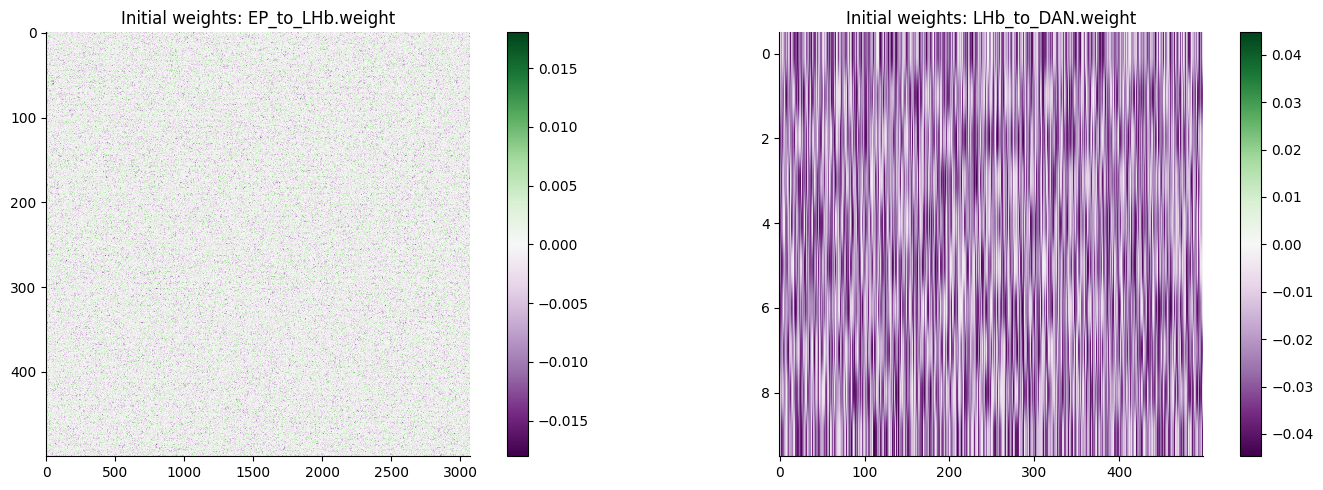

In [10]:
# Save the initial weights
initial_params_corelease = corelease_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

Epoch [1/20], Loss: 2.1424
Epoch [2/20], Loss: 2.2126
Epoch [3/20], Loss: 2.1811
Epoch [4/20], Loss: 2.2042
Epoch [5/20], Loss: 2.1391
Epoch [6/20], Loss: 2.2431
Epoch [7/20], Loss: 2.1597
Epoch [8/20], Loss: 2.1149
Epoch [9/20], Loss: 2.1432
Epoch [10/20], Loss: 2.2309
Epoch [11/20], Loss: 2.1180
Epoch [12/20], Loss: 2.1667
Epoch [13/20], Loss: 2.2094
Epoch [14/20], Loss: 2.1689
Epoch [15/20], Loss: 2.1418
Epoch [16/20], Loss: 2.1522
Epoch [17/20], Loss: 2.1949
Epoch [18/20], Loss: 2.2598
Epoch [19/20], Loss: 2.1591
Epoch [20/20], Loss: 2.2566


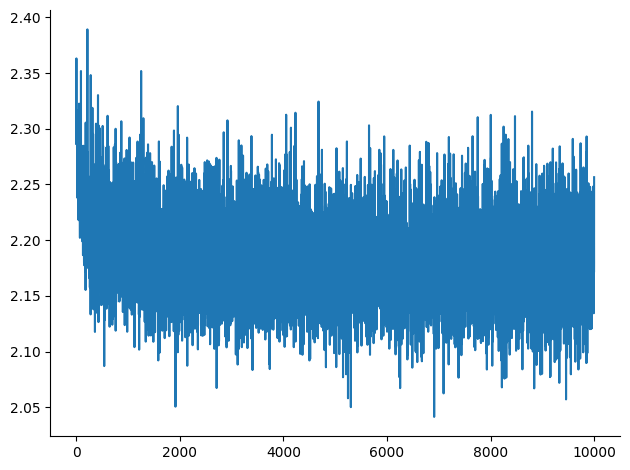

In [11]:
# Train the network
training_loss = corelease_net.train_model(num_epochs,train_loader,optimizer,loss='CrossEntropyLoss')
cr_training_loss.extend(training_loss)

# Plot training loss
plt.plot(cr_training_loss)

In [12]:
# Evaluating the accuracy of the model
correct = 0
total = 0
for images,labels in test_loader:
  images = images.view(-1,input_size) #.cuda()
  labels = labels #.cuda()

  with torch.no_grad():
    output = corelease_net(images)
    _, predicted = torch.max(output,1)
    correct += (predicted == labels).sum()
    total += labels.size(0)

print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

Accuracy of the model: 9.999 %


EP_to_LHb.weight
 Positive: 56.137824058532715%; Negative: 43.862175941467285%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 50.599998235702515%; Negative: 49.39999878406525%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 94.9400007724762%; Zero: 5.059999972581863%
LHb_to_DAN.bias
 Positive: 40.00000059604645%; Negative: 60.00000238418579%; Zero: 0.0%


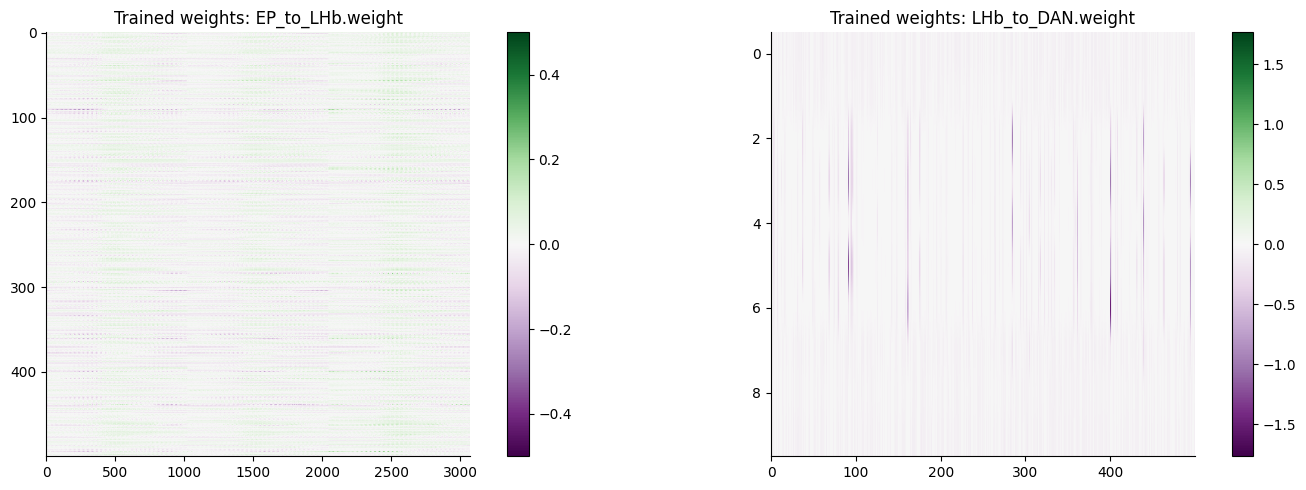

In [13]:
# Save the trianed parameters in paramList
trained_params_corelease = corelease_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(trained_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  42.231% (648666/1536000)
EP_to_LHb.bias flipped:  49.000% (245/500)
LHb_to_DAN.weight flipped:  0.000% (0/5000)
LHb_to_DAN.bias flipped:  30.000% (3/10)
EP_to_LHb.weight changed:  100.000% (1536000/1536000)
EP_to_LHb.bias changed:  100.000% (500/500)
LHb_to_DAN.weight changed:  100.000% (5000/5000)
LHb_to_DAN.bias changed:  100.000% (10/10)


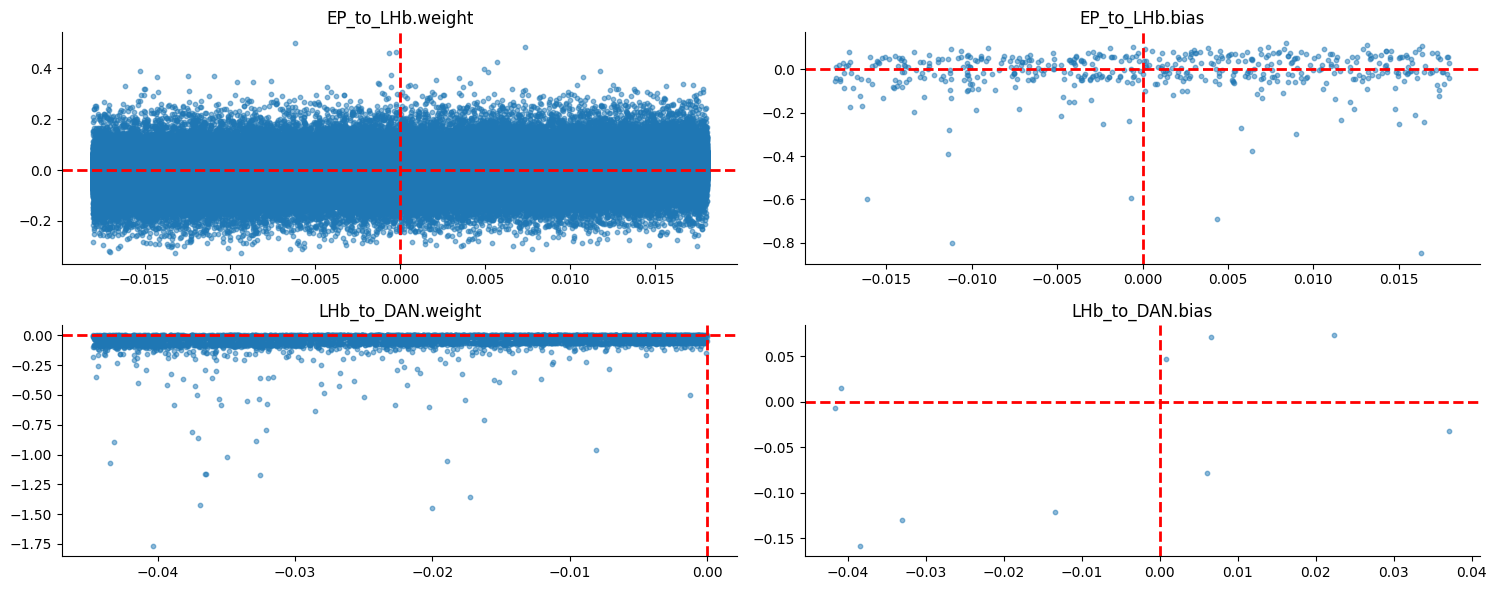

In [14]:
#@title What fraction of parameters flip sign?
for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_flip = (initial_params_corelease[key].sign()*trained_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_changed = (initial_params_corelease[key] != trained_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_corelease)[i]
    ax.scatter(initial_params_corelease[key].numpy(),trained_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Fixed-sign MLP

In [15]:
fixed_sign_net = EPLHb(input_size,hidden_size,output_size,fixed_sign=True,neg_output=True)
if torch.cuda.is_available(): fixed_sign_net.cuda()

# fs_optimizer = gd(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
fs_optimizer = adam(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
fs_training_loss = []

EP_to_LHb.weight
 Positive: 50.13020634651184%; Negative: 49.86972510814667%; Zero: 6.51041659693874e-05%
EP_to_LHb.bias
 Positive: 50.199997425079346%; Negative: 49.799999594688416%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 50.0%; Zero: 0.0%


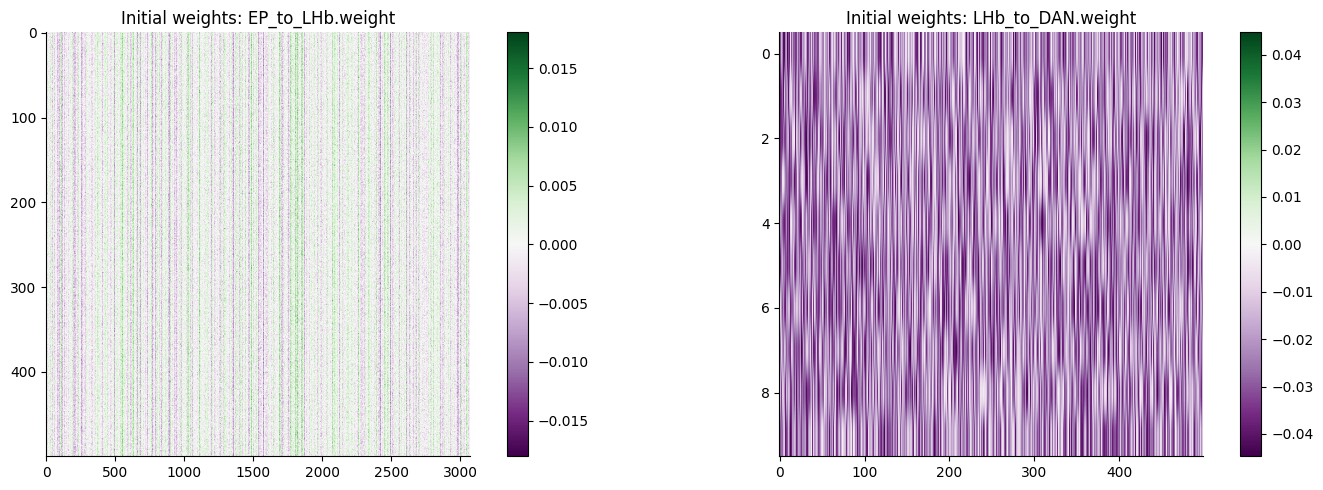

In [16]:
# Save the initial weights
initial_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [17]:
# Training fixed sign model
training_loss = fixed_sign_net.train_model(num_epochs,train_loader,fs_optimizer,loss='CrossEntropyLoss')
fs_training_loss.extend(training_loss)

Epoch [1/20], Loss: 2.1505
Epoch [2/20], Loss: 2.1082
Epoch [3/20], Loss: 2.1152
Epoch [4/20], Loss: 2.1544
Epoch [5/20], Loss: 2.1416
Epoch [6/20], Loss: 2.0263
Epoch [7/20], Loss: 1.9992
Epoch [8/20], Loss: 2.0946
Epoch [9/20], Loss: 1.9837
Epoch [10/20], Loss: 1.9838
Epoch [11/20], Loss: 1.9335
Epoch [12/20], Loss: 1.9138
Epoch [13/20], Loss: 1.9916
Epoch [14/20], Loss: 1.9740
Epoch [15/20], Loss: 1.8275
Epoch [16/20], Loss: 1.8880
Epoch [17/20], Loss: 1.7706
Epoch [18/20], Loss: 1.9041
Epoch [19/20], Loss: 1.8038
Epoch [20/20], Loss: 1.8145


Accuracy of the model: 34.217 %


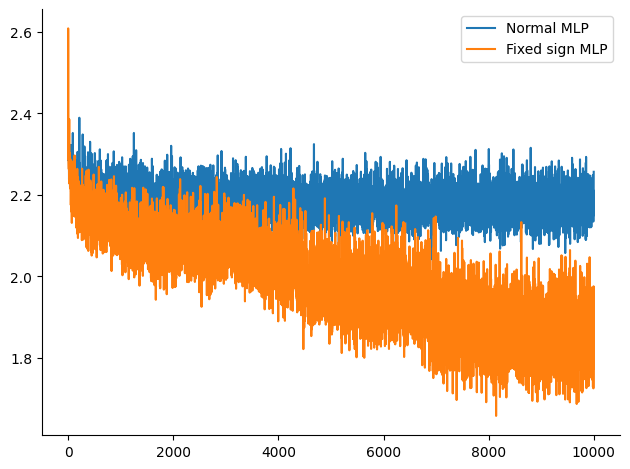

In [18]:
#Evaluating the accuracy of the model
correct = 0
total = 0
for images,labels in test_loader:
  images = images.view(-1,input_size) #.cuda()
  labels = labels #.cuda()

  with torch.no_grad():
    output = fixed_sign_net(images)
    _, predicted = torch.max(output,1)
    correct += (predicted == labels).sum()
    total += labels.size(0)

print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

# Plot training loss history
plt.plot(cr_training_loss, label='Normal MLP')
plt.plot(fs_training_loss, label='Fixed sign MLP')
plt.legend()

EP_to_LHb.weight
 Positive: 49.711328744888306%; Negative: 37.86490857601166%; Zero: 12.423762679100037%
EP_to_LHb.bias
 Positive: 49.799999594688416%; Negative: 34.99999940395355%; Zero: 15.199999511241913%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 99.1599977016449%; Zero: 0.839999970048666%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 50.0%; Zero: 0.0%


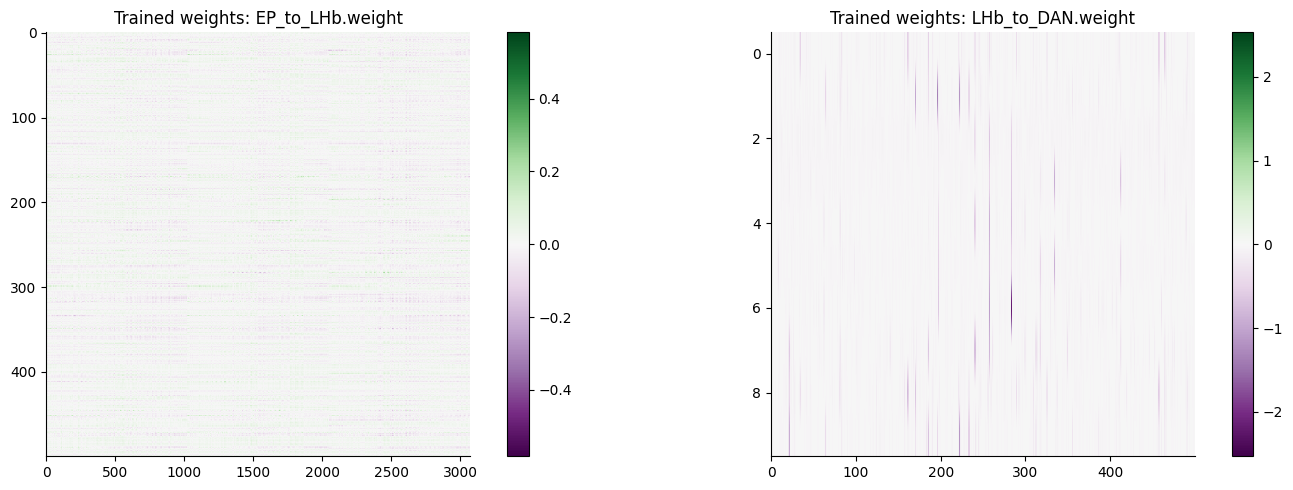

In [19]:
# Save the trianed parameters in paramList
trained_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  0.000% (0/1536000)
EP_to_LHb.bias flipped:  0.000% (0/500)
LHb_to_DAN.weight flipped:  0.000% (0/5000)
LHb_to_DAN.bias flipped:  0.000% (0/10)
EP_to_LHb.weight changed:  100.000% (1536000/1536000)
EP_to_LHb.bias changed:  100.000% (500/500)
LHb_to_DAN.weight changed:  100.000% (5000/5000)
LHb_to_DAN.bias changed:  100.000% (10/10)


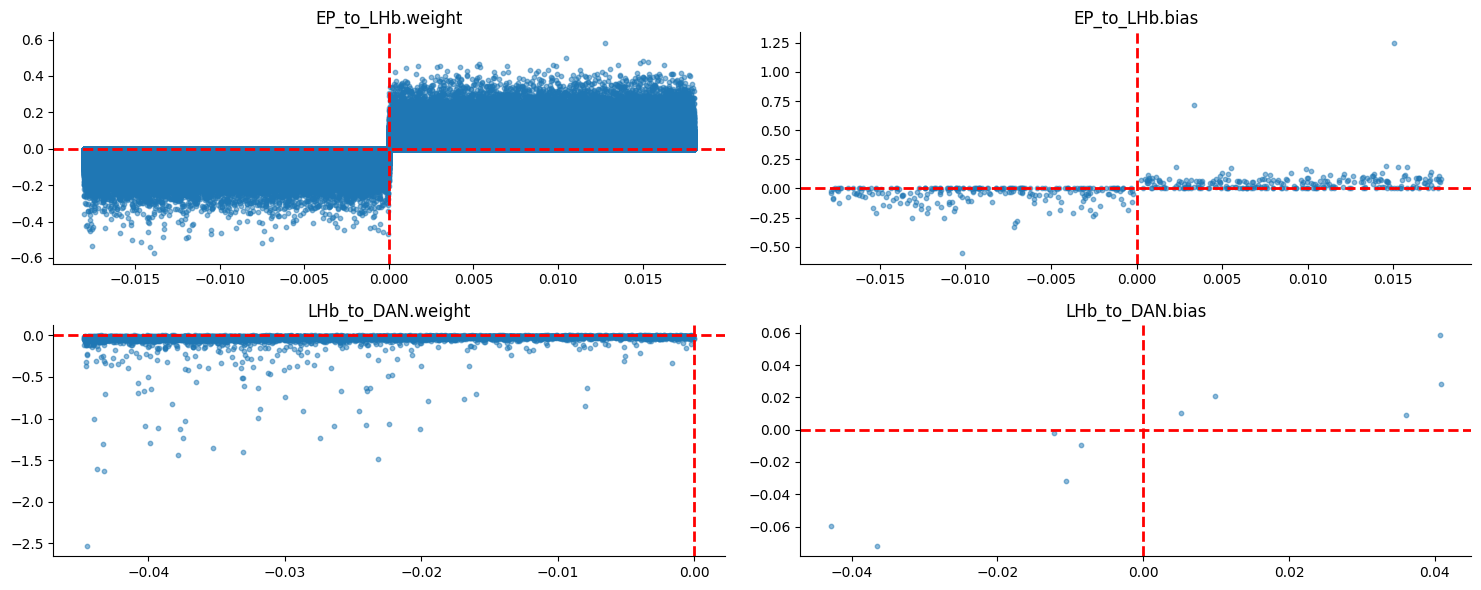

In [20]:
#@title What fraction of parameters flip sign?
for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_flip = (initial_params_fixed[key].sign()*trained_params_fixed[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_changed = (initial_params_fixed[key] != trained_params_fixed[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_fixed)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_fixed)[i]
    ax.scatter(initial_params_fixed[key].numpy(),trained_params_fixed[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Weight change analysis

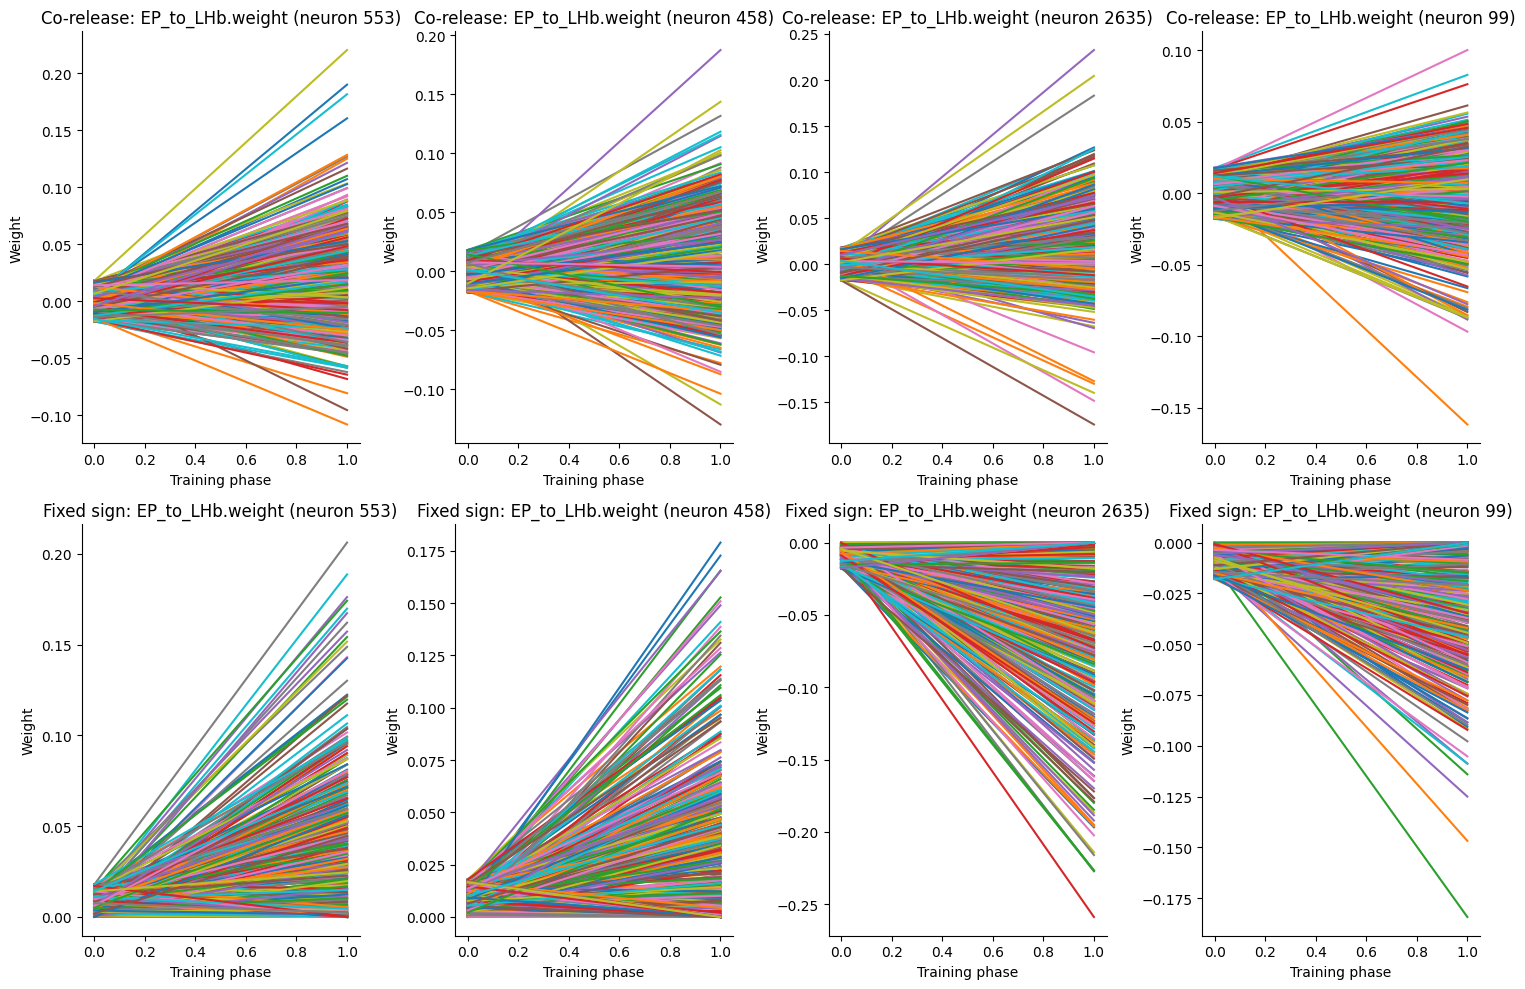

In [21]:
# Plot flipped EP neuron weight changes
n_row = 2
n_col = 4

fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

key = list(initial_params_corelease)[0]
picked_neurons = torch.randint(1,input_size,(n_col,))

for i, neuron in enumerate(picked_neurons):
    weight_history_corelease = [initial_params_corelease[key][:,neuron].flatten(),
                                trained_params_corelease[key][:,neuron].flatten()]

    weight_history_fixed = [initial_params_fixed[key][:,neuron].flatten(),
                            trained_params_fixed[key][:,neuron].flatten()]

    axs.flatten()[i].plot(weight_history_corelease)
    axs.flatten()[i].set_xlabel('Training phase')
    axs.flatten()[i].set_ylabel('Weight')
    axs.flatten()[i].set_title('Co-release: %s (neuron %d)' %(key, neuron))
    axs.flatten()[i+n_col].plot(weight_history_fixed)
    axs.flatten()[i+n_col].set_xlabel('Training phase')
    axs.flatten()[i+n_col].set_ylabel('Weight')
    axs.flatten()[i+n_col].set_title('Fixed sign: %s (neuron %d)' %(key, neuron))

plt.tight_layout()
plt.show()

## Old codes

In [22]:
# #@title Training the model
# for epoch in range(num_epochs):
#   for i ,(images,labels) in enumerate(train_gen):
#     images = images.view(-1,28*28) #.cuda()
#     labels = labels #.cuda()

#     fs_optimizer.zero_grad()
#     outputs = fixed_sign_net(images)

#     loss = loss_function(outputs, labels)
#     fs_training_loss.append(loss.data.cpu())

#     loss.backward()
#     fs_optimizer.step(init_weights=list(initial_params_fixed.values()))

#     if (i+1) % 100 == 0:
#       print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                  %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.data))

In [23]:
# #@title Define model class

# class threeLayer(nn.Module):
#   def __init__(self, input_size, hidden_size, num_classes, fixed_sign: bool = False):
#     super(threeLayer,self).__init__()
#     self.fc1 = nn.Linear(input_size, hidden_size)
#     nn.init.xavier_normal_(self.fc1.weight)
    
#     self.fcOut = nn.Linear(hidden_size, num_classes)
#     nn.init.xavier_normal_(self.fcOut.weight)

#     self.relu = nn.ReLU()

#     # Turn into fixed sign (obey Dale's law)
#     with torch.no_grad():
#       self.fixed_sign = fixed_sign
#       pos_neurons = {}
#       neg_neurons = {}
#       if fixed_sign:
#         for name, param in self.named_parameters():
#           if "weight" in name:
#             # Find each neuron is excitatory or inhibitory
#             pos_neurons[name] = torch.sum(param.data, axis=0) >= 0
#             neg_neurons[name] = torch.sum(param.data, axis=0) < 0
#             # Make all weights of that neuron excitatory or inhibitory
#             param.data[:,pos_neurons[name]] = torch.sign(param[:,pos_neurons[name]])*param[:,pos_neurons[name]]
#             param.data[:,neg_neurons[name]] = -torch.sign(param[:,neg_neurons[name]])*param[:,neg_neurons[name]]

#     # Store original weights information
#     self.pos_neurons = pos_neurons
#     self.neg_neurons = neg_neurons

#   def forward(self,x):
#     out = self.fc1(x)
#     out = self.relu(out)
#     out = self.fcOut(out)
#     return out